In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import alphashape
from pyproj import Proj, Geod
import ast
import matplotlib.font_manager as font_manager

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

data_path = '../../data/'  
polygon_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')

## Goal of this notebook

The goal of this notebook is to optimize the matching process between the detector network and the "main roads" of OpenStreetMap. 

In [2]:
def line_length_in_meters(line_string):
    # Define a UTM projection for the zone containing your coordinates
    utm_zone = 31  # Assuming you are in Paris, which falls in UTM zone 31 for example
    proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Extract coordinates from the LineString
    coordinates = list(line_string.coords)

    # Transform the coordinates to UTM projection
    utm_coordinates = [proj(lon, lat) for lon, lat in coordinates]

    # Compute the distance between consecutive points in meters
    total_length = 0
    geod = Geod(ellps='WGS84')
    for i in range(len(utm_coordinates) - 1):
        lon1, lat1 = utm_coordinates[i]
        lon2, lat2 = utm_coordinates[i + 1]
        distance_meters = geod.inv(lon1, lat1, lon2, lat2)[-1]  # Use [-1] to get distance

        # Handle case of very small distances
        if np.isnan(distance_meters):
            dx = lon2 - lon1
            dy = lat2 - lat1
            distance_meters = np.sqrt(dx**2 + dy**2)
        total_length += distance_meters

    return total_length

def is_na_list(lst):
    return lst is None or len(lst) == 0 or all(pd.isna(x) for x in lst)

def parse_and_average_lanes(lanes_str):
    if isinstance(lanes_str, list):
        if is_na_list(lanes_str):
            return np.nan
        else: 
            return sum(map(int, lanes_str)) / len(lanes_str)
    else:
        if pd.isna(lanes_str):  # Check if input is NaN
            return np.nan  # Return NaN if input is NaN
    try:
        # Attempt to parse the string as a list
        lanes_list = ast.literal_eval(lanes_str)
        if isinstance(lanes_list, list):
            # If it's a list, calculate the average of list elements
            return sum(map(int, lanes_list)) / len(lanes_list)
        else:
            # If it's a single integer, return it as is
            return int(lanes_list)
    except (SyntaxError, ValueError):
        # If parsing fails or the lanes_str is not a list, parse as single integer
        return int(lanes_str)

def approximate_number_of_lanes(df_matched):
    df_matched_with_lanes_approximated = df_matched.copy()
    average_lanes_per_highway = df_matched.groupby('highway')['lanes_mapped'].mean()
    for index, row in df_matched_with_lanes_approximated.iterrows():
        if pd.isna(row['lanes_mapped']):
            df_matched_with_lanes_approximated.at[index, 'lanes_mapped'] = average_lanes_per_highway[row['highway']]
    return df_matched_with_lanes_approximated

This notebook matches the links of the Paris counting network with the links of an OSM network:
- Load [OpenStreetMap network](https://www.openstreetmap.org/#map=7/51.330/10.453)
- Load [detector network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Load networks

In [31]:
# perform it for years 2013 - 2024. For some reason, one cannot retrieve detector data from OSM from before 2013.
year = 2024

output_path = "output/detectors_matched_2_osm_01_" + str(year)

In [32]:
# get OSM dataframe
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

overpass_settings = '[out:json][timeout:90][date:"' + str(year) + '-01-01T00:00:00Z"]'
print(overpass_settings)
ox.settings.overpass_settings = overpass_settings
ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

[out:json][timeout:90][date:"2024-01-01T00:00:00Z"]


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_97394/3004573801.py:13: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [33]:
df_osm.drop(columns=['width', 'bridge', 'tunnel', 'junction', 'access', 'ref'])

,osmid,oneway,name,highway,maxspeed,reversed,length,geometry,lanes,node_start,node_end,osm_id
0,4039102,True,Rue de Buzenval,residential,30,False,129.019,"LINESTRING (2.40137 48.85185, 2.40133 48.85192...",NaN,0,3202,1
1,54830382,False,Rue d'Avron,tertiary,30,False,62.470,"LINESTRING (2.40137 48.85185, 2.40128 48.85184...",2,0,5256,2
2,54830382,False,Rue d'Avron,tertiary,30,True,201.182,"LINESTRING (2.40137 48.85185, 2.40151 48.85188...",2,0,5431,3
3,32137109,True,Avenue de Gravelle,tertiary,30,False,12.581,"LINESTRING (2.40116 48.82954, 2.40127 48.82955...",2,1,8320,4
4,84416296,False,Rue de Tolbiac,secondary,30,False,154.093,"LINESTRING (2.36150 48.82635, 2.36186 48.82639...",3,2,6560,5
...,...,...,...,...,...,...,...,...,...,...,...,...
16549,1233389798,True,Boulevard de Magenta,primary,30,False,98.058,"LINESTRING (2.35576 48.87652, 2.35582 48.87641...",1,8576,8575,16550
16550,1233389798,True,Boulevard de Magenta,primary,30,False,5.306,None,1,8577,8576,16551
16551,1233389796,True,Boulevard de Magenta,secondary,30,False,31.920,"LINESTRING (2.35573 48.87656, 2.35592 48.87640...",2,8577,47,16552
16552,1233389795,True,Boulevard de Magenta,primary,30,False,29.072,"LINESTRING (2.35560 48.87681, 2.35570 48.87663...",2,8578,8577,16553


In [34]:
# Filter osm network for higher order roads
df_osm_hor = df_osm[
    df_osm["highway"].str.contains("motorway") |
    df_osm["highway"].str.contains("trunk") |
    df_osm["highway"].str.contains("primary") |
    df_osm["highway"].str.contains("secondary") |
    df_osm["highway"].str.contains("tertiary")
]
df_osm_hor = df_osm_hor[df_osm_hor['geometry'].notnull()]

In [35]:
# process car detectors -> only consider those inside polygon

boundary_gdf = gpd.GeoDataFrame(
    geometry=[polygon], crs=df_car_detectors.crs)
df_car_detectors_without_dupl = df_car_detectors.drop_duplicates(
    subset='iu_ac', keep='first')
car_detectors_within_boundary = gpd.sjoin(
    df_car_detectors_without_dupl, boundary_gdf, op='within')
df_detectors = car_detectors_within_boundary.copy()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [54]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance. alpha = 0.9 seemed to get the best matching. Keep in mind that we normalize the absolute difference of centroid 
# distance and angle difference is done in the score computation. 
alpha = 0.7


# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

## Plot data

In [55]:
# fig, ax = plt.subplots()
# df_detectors.plot(ax=ax)

In [56]:
# fig, ax = plt.subplots()
# df_osm.plot(ax=ax)

In [57]:
# fig, ax = plt.subplots()
# df_osm_hor.plot(ax=ax)

## Matching

In [58]:
# Calculate centroids
detector_centroids = np.vstack([
    df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T

osm_centroids = np.vstack([
    df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_97394/3904791298.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_97394/3904791298.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T


In [59]:
# Calculate orientation

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    
detector_angles = df_detectors["geometry"].apply(angle).values
osm_angles = df_osm_hor["geometry"].apply(angle).values

In [60]:
# Calculate n-to-m distances
centroid_distances = np.zeros((len(detector_centroids), len(osm_centroids)))
angle_distances = np.zeros((len(detector_centroids), len(osm_centroids)))

In [61]:
for k in tqdm(range(len(detector_centroids))):
    centroid_distances[k,:] = la.norm(detector_centroids[k] - osm_centroids, axis = 1)
    angle_distances[k,:] = np.abs(detector_angles[k] - osm_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/2719 [00:00<?, ?it/s]

In [62]:
# Prepare scoring / matching
# We add the 0.1 for the angle_distances to normalize a bit..
# TODO normalize more .. angle_distances.mean() is about 39.23 times bigger than centroid_distances.mean()

normalization_variable = angle_distances.mean()/centroid_distances.mean()

scores = alpha + centroid_distances + (1-alpha) * normalization_variable * angle_distances

# Deactivate improbable matchings
scores[centroid_distances > maximum_distance] = np.inf
scores[angle_distances > maximum_angle] = np.inf

In [63]:
# Matching process
matchings = []
matched_scores = []

# The idea is relatively simple:
# - Find the matching with the smallest score among those with a finite value
# - Note down the matching, and set all matching containing the two links to Inf
# - Continue until no scores with finite value are left

current = np.count_nonzero(~np.isfinite(scores))

with tqdm(total = np.prod(scores.shape) - current) as progress:
    while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
        index = np.unravel_index(np.argmin(scores), scores.shape)
        matched_scores.append(scores[index])

        # Set both invlved links to Inf
        scores[index[0], :] = np.inf
        scores[:, index[1]] = np.inf
        
        # Manage progress plotting
        update = np.count_nonzero(~np.isfinite(scores))
        
        if update > current:
            progress.update(update - current)
            current = update

        matchings.append(index)
        
matchings = np.array(matchings) # The matchings themselves (index reference, index matsim)
matched_scores = np.array(matched_scores) # The scores of the matchings

  0%|          | 0/1572691 [00:00<?, ?it/s]

## Output

In [64]:
# Construct a data set containing all matching information
df_matching = pd.DataFrame({
    "iu_ac": df_detectors.iloc[matchings[:, 0]]["iu_ac"].values,
    "geometry_detector": df_detectors.iloc[matchings[:, 0]]["geometry"].values,
    "osm_id": df_osm_hor.iloc[matchings[:,1]]["osm_id"].values,
    "lanes": df_osm_hor.iloc[matchings[:, 1]]["lanes"].values,
    "highway": df_osm_hor.iloc[matchings[:, 1]]["highway"].values,
    "oneway": df_osm_hor.iloc[matchings[:, 1]]["oneway"].values,
    "length_mapped_osm_street": df_osm_hor.iloc[matchings[:, 1]]["length"].values,
    "score": matched_scores
})
df_matching = df_matching.sort_values(by='iu_ac')

In [65]:
df_matching['length_detector_street'] = df_matching['geometry_detector'].apply(lambda x: line_length_in_meters(x))
df_matching['lanes_mapped'] = df_matching['lanes'].apply(parse_and_average_lanes)
df_matched_with_lanes_approximated = approximate_number_of_lanes(df_matching)

Percentile:  0.6
2719
1631
Percentile:  0.7
2719
1903
Percentile:  0.8
2719
2175
Percentile:  0.9
2719
2447


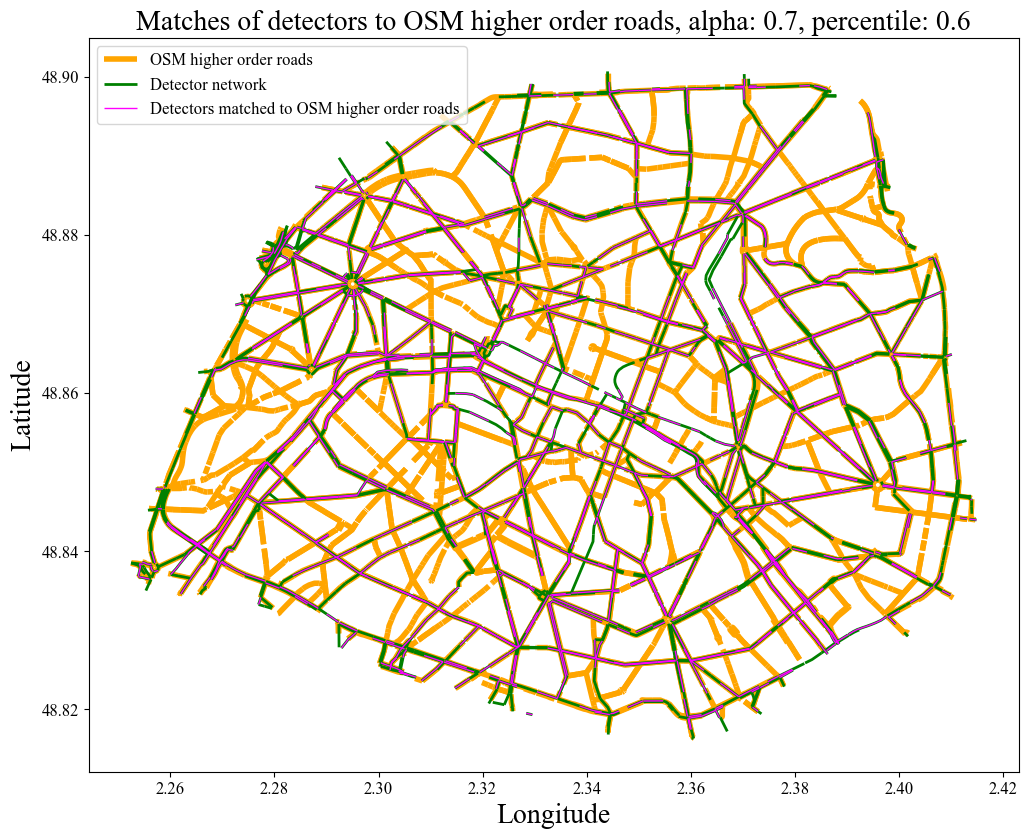

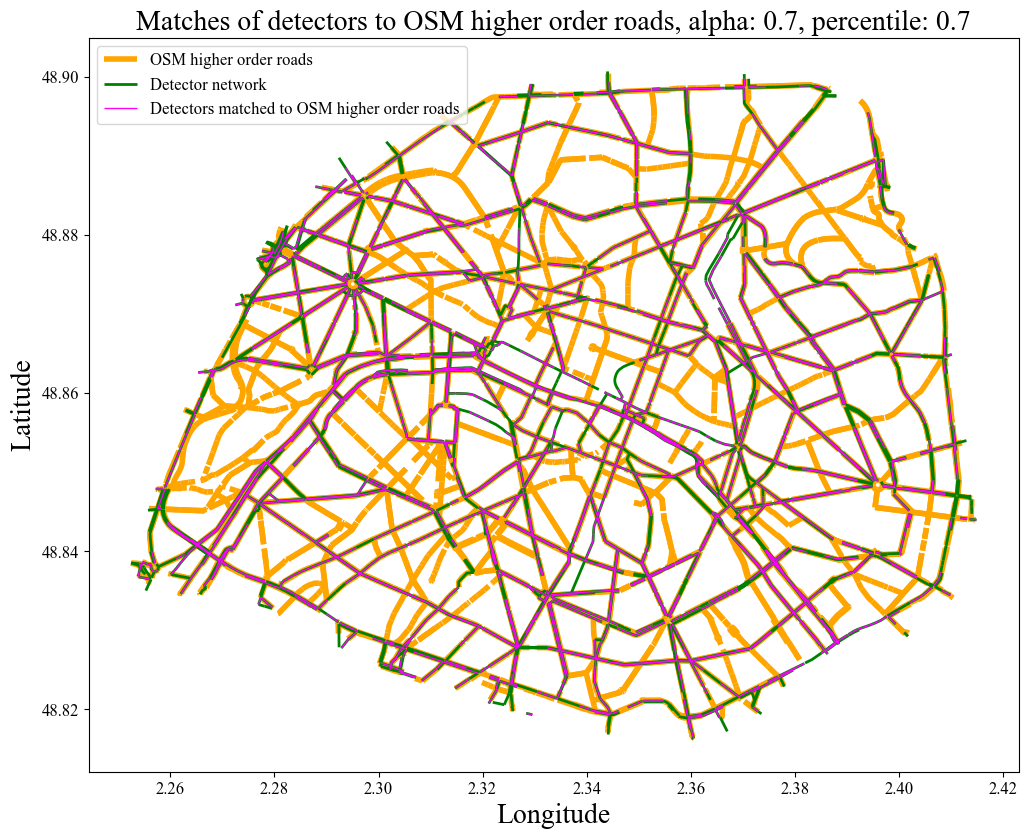

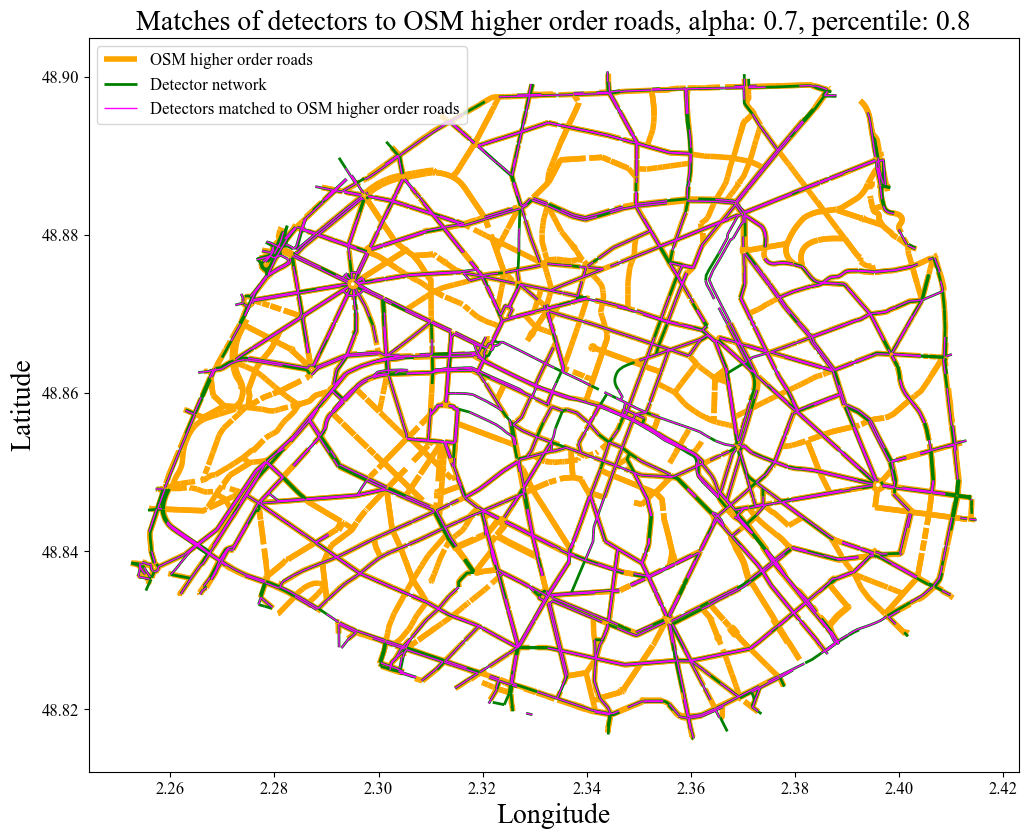

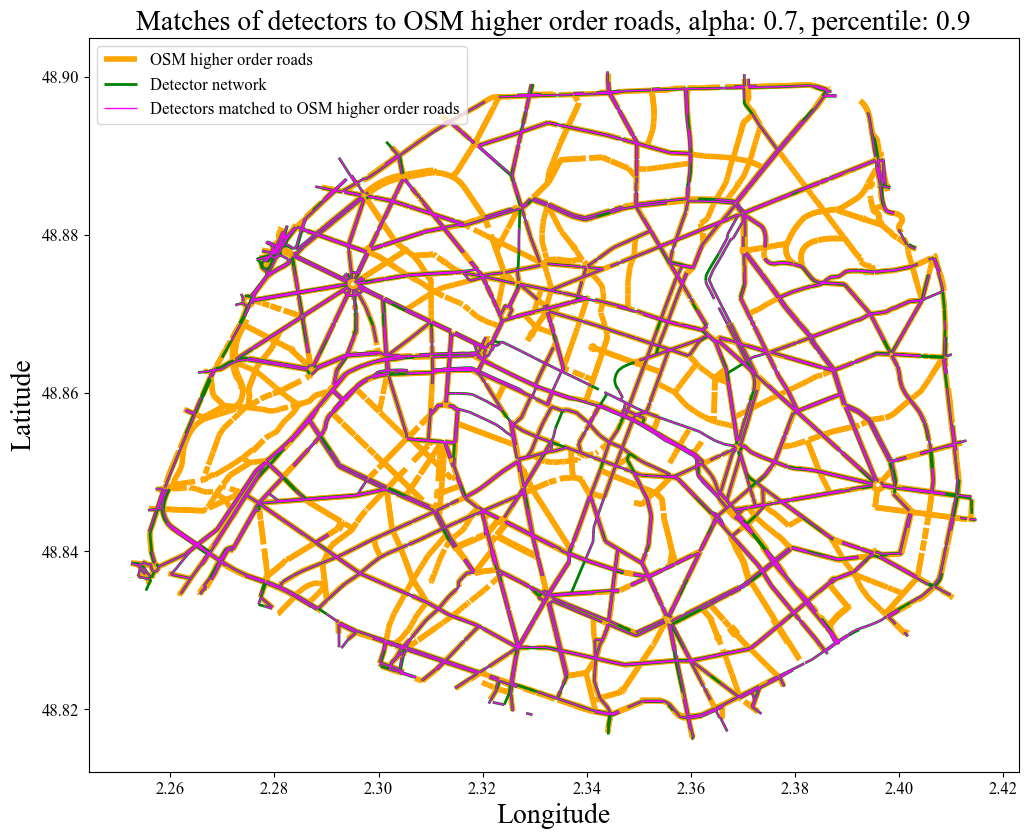

In [66]:
for p in [0.6, 0.7, 0.8, 0.9]:
    print("Percentile: ", p)
    percentile = df_matched_with_lanes_approximated['score'].quantile(p)
    
    # filter out the matches with the highest score
    df_matching_best = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['score'] < percentile]

    print(len(df_matched_with_lanes_approximated))
    print(len(df_matching_best))
    gdf_matched = gpd.GeoDataFrame(df_matching_best, geometry='geometry_detector')

    fig, ax = plt.subplots(figsize=(12, 10))
    df_osm_hor.plot(ax=ax, color = 'orange', linewidth = 4, label = "OSM higher order roads")
    df_detectors.plot(ax=ax, linewidth=2, color = "green", label = "Detector network")
    gdf_matched.plot(ax=ax, color = 'magenta', linewidth=1, label = "Detectors matched to OSM higher order roads")

    plt.xlabel("Longitude", font = font, fontsize = fontsize)
    plt.ylabel("Latitude", font = font, fontsize = fontsize)
    plt.title("Matches of detectors to OSM higher order roads," + " alpha: " + str(alpha) + ", percentile: " + str(p), font = font, fontsize = fontsize)
    plt.xticks(font = font, fontsize = 12)
    plt.yticks(font = font, fontsize = 12)
    
    font_legend = font_manager.FontProperties(family=font, style='normal', size=12)
    plt.legend(loc='upper left', prop = font_legend)
    # plt.savefig("results/matched_alpha_" + str(alpha) +  "_p_" + str(p) + ".pdf", dpi=1000, bbox_inches='tight')

# Plot

In [67]:
# fig, ax = plt.subplots(figsize=(12, 10))
# # df_matching_best.plot(ax=ax, color = 'magenta', linewidth=1, label = "Matches")
# df_osm_hor.plot(ax=ax, color = 'orange', linewidth = 4, label = "OSM higher order roads")
# df_detectors.plot(ax=ax, linewidth=1, color = "green", label = "Detectors")

# plt.xlabel("Longitude", font = font, fontsize = fontsize)
# plt.ylabel("Latitude", font = font, fontsize = fontsize)
# plt.title("Paris - OSM higher order roads and detector matches", font = font, fontsize = fontsize)

# plt.xticks(font = font, fontsize = fontsize)
# plt.yticks(font = font, fontsize = fontsize)
# font_legend = font_manager.FontProperties(family=font, style='normal', size=15)
# plt.legend(loc='upper left', prop = font_legend)

# plt.savefig("results/osm_hor_and_detectors.pdf", dpi=1000)

In [68]:
# save the results

df_matching_best.to_csv(output_path + "_best_matches.csv", sep=";", index=False)
df_matched_with_lanes_approximated.to_csv(output_path + ".csv", sep=";", index=False)

In [69]:
# df_comparison = df_detectors.copy()
# df_comparison = pd.merge(df_comparison, df_matching)
# df_comparison.to_file("output/detectors_matched_2_osm.geojson", driver = 'GeoJSON')

In [70]:
# osm_matched_2_detectors = df_osm_hor.copy()
# osm_matched_2_detectors = pd.merge(osm_matched_2_detectors, df_matching)
# osm_matched_2_detectors.to_file(
#     "output/osm_matched_2_detectors.geojson", driver='GeoJSON')